# CNN Project

##### Imports

In [20]:
# import sys
!{sys.executable} -m pip install opencv-python

     |████████████████████████████████| 51.0 MB 13.3 MB/s eta 0:00:01


In [12]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, InputLayer, Conv2D, UpSampling2D, DepthwiseConv2D
from tensorflow.keras.layers import Flatten, MaxPooling2D, Conv2DTranspose, AveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image
from tensorflow.keras.utils import plot_model
from math import ceil
import random
import cv2
from skimage import io, color

##### Convert Images

In [2]:
os.getcwd()

'/eos/home-c/crandazz/SWAN_projects/Machine Learning'

In [34]:
rootdir = os.getcwd()
# filenames = random.sample(os.listdir('...path...'), 500)
filenames = ['Data/ImageFiles/S41eRa.jpg']
lspace = []
abspace = []
for file in filenames:
    rgb = io.imread(file)
    lab_image = cv2.cvtColor(rgb,cv2.COLOR_BGR2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab_image)
    lspace.append(l_channel)
    replot_lab = np.zeros((256,256,2))
    replot_lab[:,:,0] = a_channel
    replot_lab[:,:,1] = b_channel
    abspace.append(replot_lab)
    transfer = cv2.merge([l_channel, a_channel, b_channel])
    transfer = cv2.cvtColor(transfer.astype('uint8'), cv2.COLOR_LAB2BGR)

lspace = np.asarray(lspace)
abspace = np.asarray(abspace)

In [35]:
rgb.shape

(256, 256, 3)

In [36]:
#3 matrices, 256x256-red, 256x256-green, 256x256-blue  ...each matrix is rgb[:,:,1],rgb[:,:,2],[:,:,3] respectively
rgb[:,:,0] #a_channel containing the ?yellow/green? values

array([[235, 237, 244, ..., 143, 180, 183],
       [ 95, 105, 121, ..., 250, 251, 250],
       [  1,   2,   4, ..., 110, 105, 105],
       ...,
       [254, 254, 255, ..., 192, 155, 129],
       [255, 255, 255, ..., 190, 153, 125],
       [255, 254, 254, ..., 187, 148, 118]], dtype=uint8)

In [37]:
# np.set_printoptions(threshold=1000)
np.set_printoptions(threshold=np.inf)
display(rgb[:,:,0].shape) #red
display(rgb[:,:,1].shape) #green
display(rgb[:,:,2].shape) #blue

(256, 256)

(256, 256)

(256, 256)

In [38]:
# This is the grayscale matrix. A single 256x256 matrix that specifies the gray scale
# Black and White color scale
lspace.shape

(1, 256, 256)

In [33]:
lspace

(1, 256, 256)

In [7]:
np.set_printoptions(threshold=1000)
lspace # our max luminescence(grey scale) value is 255 for a total rage of 256 from 0-255 as possible values

array([[[241, 244, 250, ..., 155, 192, 195],
        [105, 118, 136, ..., 254, 255, 255],
        [  1,   2,   5, ..., 120, 115, 117],
        ...,
        [255, 255, 255, ..., 216, 193, 174],
        [254, 254, 255, ..., 214, 189, 168],
        [254, 253, 254, ..., 212, 185, 162]]], dtype=uint8)

In [39]:
# The first matrix is the Red-Green scale, the second is the Blue-Yellow [0,:,:,0] and [0,:,:,1] respectively
# This is the color matrix (lab style color system), each matrix is 256x256-
abspace.shape #256 possible values, 0-255 is range of either channels a/b where...
 #a channel is green/red,  ..green from 0-126, red from 128-255, balance at 127 
 #b channel is blue/yellow, ..blue from 0-126, yellow from 128-55, balance at 127
 #(or so I think)

(1, 256, 256, 2)

In [9]:
abspace[0,:,:,0] #a channel

array([[132., 130., 130., ..., 127., 128., 128.],
       [132., 130., 129., ..., 128., 127., 127.],
       [128., 128., 128., ..., 130., 130., 129.],
       ...,
       [128., 128., 128., ..., 129., 130., 130.],
       [129., 129., 128., ..., 129., 131., 132.],
       [129., 129., 128., ..., 129., 131., 132.]])

In [10]:
abspace[0,:,:,1] #b channel

array([[130., 131., 131., ..., 130., 131., 131.],
       [130., 131., 132., ..., 130., 130., 130.],
       [128., 129., 130., ..., 129., 129., 130.],
       ...,
       [128., 128., 128., ..., 138., 145., 149.],
       [127., 127., 128., ..., 138., 144., 148.],
       [127., 127., 128., ..., 138., 145., 148.]])

Trying to scale the values inside the matrix to the values that are expressed in Atlas's heatmap:

if values are from
- 0-255 and (256 possible)
- green and blue are from 0-127   (128 possible)
- red and yellow are from 128-255 (128 possible)
- a channel combines green/red   for 0-127,128-255
- b channel combines blue/yellow for 0-127,128-255

<b>THUS, in order to prepare our data quality data in the format this thing recognizes...</b>
- a single gray scale marix is (256,256,1) where rows=x,columns=y,z=occ and is the data values for a 2d TH2 hist
- typically, when representing a TH2 file as a heatmap it contains x data, y data, and the occupancy gives it a red/blue color scale depending on the total values. if it were devided by 2 then black would be 256/2 or 128 and 129 while the upper and lower limits would be blue as 0 and red as 256

In [32]:
lspace.shape #grey scale matrix

(1, 256, 256)

##### Load the Data

Just for fun, we will turn the grey scale into a dataframe and visualize it as a heatmap:

In [17]:
# Convert Grey space matrix shape (1,256,256) to dataframe
columns = []
for i in range(256):
    columns.append('Y_'+str(i))

tmp = pd.DataFrame(lspace[0], columns = columns)

In [20]:
tmp

,Y_0,Y_1,Y_2,Y_3,Y_4,Y_5,Y_6,Y_7,Y_8,Y_9,...,Y_246,Y_247,Y_248,Y_249,Y_250,Y_251,Y_252,Y_253,Y_254,Y_255
0,241,244,250,250,252,255,254,253,255,255,...,182,165,161,166,190,177,139,155,192,195
1,105,118,136,144,142,138,135,135,134,141,...,253,253,253,253,253,255,254,254,255,255
2,1,2,5,7,5,1,1,3,9,16,...,152,143,137,127,115,113,119,120,115,117
3,7,1,0,0,0,1,5,16,45,54,...,15,12,7,9,5,1,2,6,7,3
4,1,3,3,1,2,2,1,2,7,8,...,35,32,34,19,7,1,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,254,254,255,255,255,255,255,255,255,255,...,255,255,255,255,254,254,242,223,205,187
252,251,255,255,255,255,255,255,255,255,255,...,255,254,255,255,254,251,238,219,199,179
253,255,255,255,255,255,254,255,255,255,255,...,255,255,254,255,255,248,236,216,193,174
254,254,254,255,255,255,255,255,255,255,255,...,255,255,255,255,254,247,234,214,189,168


<AxesSubplot:>

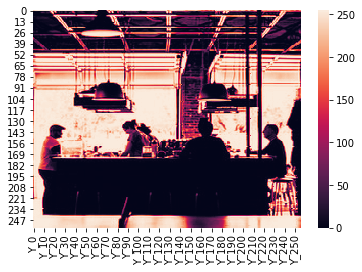

In [81]:
# import seaborn as sns
sns.heatmap(tmp)

And Now, we can convert the dataframe we constructed back to a numpy array... we can do the same thing when we have a dataframe from a hist file:

In [82]:
tmp.to_numpy()

array([[241, 244, 250, ..., 155, 192, 195],
       [105, 118, 136, ..., 254, 255, 255],
       [  1,   2,   5, ..., 120, 115, 117],
       ...,
       [255, 255, 255, ..., 216, 193, 174],
       [254, 254, 255, ..., 214, 189, 168],
       [254, 253, 254, ..., 212, 185, 162]], dtype=uint8)

Back to the main procedure:

In [28]:
# Issue - theres only a single image, therefore theres only a single 256x256 matrix that becomes the X variable...so when we set test_inp as X[2:,] ..it gets nothing..we need at least 
# 2 more image as inputs to test this thing
lspace.shape

(1, 256, 256)

In [29]:
#files created from above code ..just run the code and set X to lspace and Y to abspace
# X = np.load('lspace100.npy')
# Y = np.load('abspace100.npy')
X = lspace
Y = abspace

##### Structure the Model

In [40]:
model6 = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
model = Sequential()
model.add(InputLayer(input_shape=(X.shape[1], X.shape[2], 1)))
model.add(layers.Dense(units=3))
model.add(Model(inputs=model6.inputs, outputs=model6.layers[-10].output))
model.add(UpSampling2D(size=(2,2)))
model.add(UpSampling2D(size=(2,2)))
model.add(DepthwiseConv2D(32,(2,2), activation='tanh', padding='same'))
model.add(UpSampling2D(size=(2,2)))
model.add(DepthwiseConv2D(32,(2,2), activation='tanh', padding='same'))
model.add(layers.ReLU(0.3))
model.add(layers.Dropout(0.4))
model.add(UpSampling2D(size=(2,2)))
model.add(UpSampling2D(size=(2,2)))
model.add(DepthwiseConv2D(2,(2,2), activation='tanh', padding='same'))
model.add(layers.ReLU(0.3))
model.add(layers.Dropout(0.2))
model.add(UpSampling2D(size=(2,2)))
model.add(layers.ReLU(0.3))
model.add(layers.Dropout(0.2))
model.add(AveragePooling2D(pool_size = (2,2)))
model.add(layers.Dense(units=2))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256, 256, 3)       6         
_________________________________________________________________
functional_1 (Functional)    (None, 64, 64, 256)       1735488   
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 128, 128, 256)     0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 256, 256, 256)     0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 128, 128, 256)     262400    
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 256, 256, 256)     0         
_________________________________________________________________
depthwise_conv2d_1 (Depthwis (None, 128, 128, 256)     2

##### Set Model Parameters

In [41]:
def adam_optimizer():
    return Adam(lr = 0.001, beta_1=0.99, beta_2=0.999)
model.compile(loss='mape', optimizer=adam_optimizer())

##### Data Preparation

In [31]:
# Issue 
X.shape

(1, 256, 256)

In [42]:
# Issue
X[testsize:,]

NameError: name 'testsize' is not defined

In [43]:
X = ((X.reshape(X.shape[0],X.shape[1],X.shape[2],1)))
X = (X-255)/255
Y = (Y-255)/255

trainsize = ceil(0.8 * X.shape[0])
testsize = ceil(0.2 * X.shape[0])+1

train_inp = X[:trainsize,]
test_inp = X[testsize:,]

train_out = Y[:trainsize,]
test_out = Y[testsize:,]

In [46]:
train_inp.shape

(1, 256, 256, 1)

note: the test_input will break with a single image because there is only 1 available to use on and it goes in training rather than testing

##### Train the Model

In [44]:
model.fit(x=train_inp, y=train_out, batch_size=10, epochs=5)

Epoch 1/5


KeyboardInterrupt: 

##### Obtain Predictions

In [25]:
# Issue 
test_inp

array([], shape=(0, 256, 256, 1), dtype=float64)

In [16]:
train_pred = model.predict(train_inp)
test_pred = model.predict(test_inp)

train_random=random.randint(1,trainsize)
test_random=random.randint(1,testsize)

check=np.interp(train_pred, (train_pred.min(), train_pred.max()), (0,255))

l_channel = test_inp[20]*255
a_channel=check1[20,:,:,0]
b_channel=check1[20,:,:,1]

transfer = cv2.merge([l_channel, a_channel, b_channel])
transfer = cv2.cvtColor(transfer.astype('uint8'), cv2.COLOR_LAB2BGR)

UnboundLocalError: local variable 'batch_outputs' referenced before assignment

##### View the Results

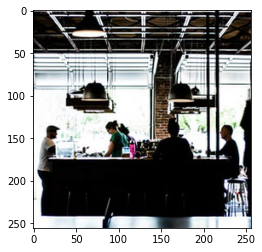

In [101]:
plt.imshow(transfer)

<hr>
<hr>
<hr>

# With that example done, now for our official model:

## creating the data matrix
we only need a 2 dimension matrix to hold 3 features (X as eta, Y as phi, Z as occupancy)

In [117]:
np.set_printoptions(threshold=np.inf)
eta_length = 64
phi_length = 64
EPO = np.zeros((eta_length,phi_length), dtype=int)
#Thus, the occupancy at eta=0 and phi=2 is... (all are currently set to 0, will populate them from dataframe)
EPO[0,2]

0

With the table setup and ideally the occupancy values populated from the dataframe(s), we must now consider how we will classify our values. Because we only have at best 4 dimensions (eta,phi,hot,cold) and this can be expressed in a single lspace like matrix (with our specified dimensions its as if the hot/cold is the light/dark values inside the grey scale matrix), so it might look something like this:
<br>
A = 
$\begin{bmatrix} 
a_{00} & a_{01} & ... & a_{0,\phi}  \\
a_{10} & a_{11} & ... & a_{1,\phi} \\
... & ... & ... & ... \\
a_{\eta,0} & a_{\eta,1} & ... & a_{\eta,\phi}
\end{bmatrix}$

<br>

At location $a_{00}$, if the value is cold as possible, it would be a 0, if it were as hot as possible it would be $o_{max}$ where $o$ is the occupancy value at location $\eta=0$,$\phi=0$

- It appears that the occupancy value for $o_{max}$ is used for the hottest value (deep red) on the chart. This means between two different kinds of histograms, the deep red value or $o_{max}$ would be different than the $o_{max}$ on other histograms, so we would not be able to compare them together unless we <b>normalized the occupancy values between histograms!</b>

- as for the x/y scale on the histogram. When the scales were converted from ROOT TH1/2 to Pandas Dataframe, the original scales were lost because in the pandas dataframe, the coordinate are for the <b>bin coordinates relative to the histogram</b> whereas <b>the actual scale(histogram scale) on the histogram that we are interested in need to be converted to and from bin scale(dataframe)</b>

- further, we 'could' give the matrix an additional feature/dimension that would represent the specific histogram that it is from. Suppose there are only 5 different kinds of histograms, then the shape of our matrix goes from ($\eta_{max}$,$\phi_{max}$) to ($\eta_{max}$,$\phi_{max}$,5) ...this is definately worth considering. It could handle the classification for the entire set of histograms we are interested in. However, the more dimensions or types of histograms it considers, the more data it will require to train the thing. For each type of histogram we are probably looking at some hundreds to thousands of histograms in the form of small memory size processed dataframes. So a single dataframe that contains all of the histograms with their respective eta,phi,occupancy values would be ideal. <b>we have this already</b> it just needs to be one-hot encoded for the histograms. 
- Additionally, we 'could' add yet another feature that would allow us to distinguish between TH1/TH2 files. But this could be going a little too far. It might be easier to do a single model per file type since there are generally only two of interest at the moment (TH1 and TH2s). We have been talking about the TH2s up until this point because they are the ones that have the eta/phi/occ dimensions. The TH1s I believe only have the eta/occupancy dimensions. 
- we also have to be careful that the Z or histogram values of each respective TH1/TH2 is actually occupancy rather than some other value. But they should classify accordingly I think as long as we account for the type of histogram

##### Lets take a look at the stuff in the bins real quick

In [1]:
import ROOT

Welcome to JupyROOT 6.16/00


In [17]:
!ls '../../../THESIS files/datafiles/'

data18_13TeV.00354176.express_express.merge.HIST.f941_h310._0001.1  July2020
data18_13TeV.00354176.physics_Main.merge.HIST.f947_h315._0001.1     test.pdf
histogram.csv


In [2]:
h_file = ROOT.TFile.Open('../../../THESIS files/datafiles/data18_13TeV.00354176.physics_Main.merge.HIST.f947_h315._0001.1')
fname = 'run_354176/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1'

In [3]:
h = h_file.Get(fname)

In [4]:
c = ROOT.TCanvas("myCanvasName", "The Canvas Title", 800, 600)

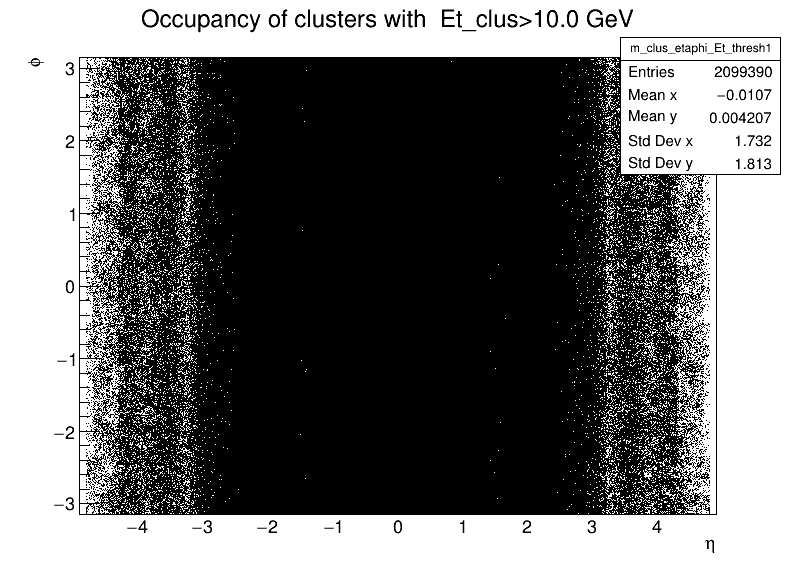

In [5]:
h.Draw()
c.Draw()

In [1]:
import ROOT
h_file = ROOT.TFile.Open('../../../THESIS files/datafiles/data18_13TeV.00354176.physics_Main.merge.HIST.f947_h315._0001.1')
fname = 'run_354176/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh1'
h = h_file.Get(fname)

Welcome to JupyROOT 6.16/00


In [ ]:
# h.GetXaxis().GetLabels()

In [5]:
h.GetZaxis().GetXmin()

0.0

In [6]:
display(h.GetXaxis().GetXmax())
display(h.GetXaxis().GetXmin())
display(h.GetYaxis().GetXmax())
display(h.GetYaxis().GetXmin())
display(h.GetNbinsX())
display(h.GetNbinsY())
display(h.GetZaxis().GetXmax())
display(h.GetZaxis().GetXmin())

4.9

-4.9

3.15

-3.15

98

64

1.0

0.0

As you can see above, if you were to compare the last two numbers ,the X and Y axis repectively, you would see that this is exactly the X/Y values that can be seen in the processed dataframe. 
- So there are 98+1 X values and 64+1 Y entries in the processed dataframe that come from here
- so the scale we need Xmax=4.9 here is at 98
- the 0 value on the scale we need is 98/2
- the Xmin=-4.9 value here then is at 0 in our dataframe
- if the total values in X is 98+1(or 99), and we need to fit 
- furthermore, we can see that the occupancy values in the z axis go from 0 to 1. This effectively is a percentage where the max occupancy from any bin located at (X,Y) can be only as much as 100% which as we expected before, will differ between histogram because the max detected occupancy will not necessarily always be the same. Especially if what is being analyzed is totally different.
those 99 values between 4.9 and -4.9 (a magnitude of 9.8 or Xmax_dataframe/2)


Why do we need to convert it to the histogram scale? Reasons. Otherwise, we need to convert these scales to the scale on the matrix that will be grey scale like. So lets take a look at this particular example what such a matrix might look like:

- we have 98+1 X values
- we have 64+1 Y values
- we have 0 to 100% of maximum occupancy Z values ..or a total of (98+1)(64+1) Z values
our matrix then will look like the following:
$
O = 
\begin{bmatrix}
\alpha_{0,0} & ... & \alpha_{98,0} \\
... \\
\alpha_{0,64} & ... & \alpha_{98,64}
\end{bmatrix}
$

where each element $\alpha_{\eta,\phi}$ is the occupancy at the bin $(\eta,\phi)$

Now, the maximum value that a color matrix can take is set, but since we aren't restricted by that, our occupancy matrix will contain the occupancies, whatever they may be for our classification model. We will just have to rewire a good bit of the CNN network because its unecessary to make it 100% like an image. Just the CNN alone hunts for solutions like it were an image. So that is enough.

When will we convert the image to hot/cold values? 
- The hot(red) values depend on the occupancy, where $\alpha_{max} = 1.0 = 100\% =$ deep red color (on root hist)
- The cold(blue) values depend on the occupancy, where $\alpha_{min} = 0.0 = 0\% =$ deep blue color (on root hist)

For the algorithm, all we need to do is use the CNN once the matrix is setup, feed it the training data, test, evaluate, etc. The part about hot/red and cold/blue values is part of the 'after the fact' modelling has been completed.

What do we need now?
We need to actually get the data. 
<b>How much do we need?</b>
 -  1000 of each individual histogram as a minimum, 10k would be better, more even better (1000-10, run files)
 - if that is impossible to get, we may need to collect similar files and reduce the total number of histograms per type
IMPORTANT, we don't just need the data->processed->dataframe, <b>the dataframe needs to include a feature that says quality</b> (0/1/2) for r/y/g for bad/warning/good. This means <b>The dataframe itself will require a slight adjustment in the processing phase because we need the new feature</b>
 

##### TODO
1. Get the 1000 or however many runs for the 1000+ histograms of each type, make sure they include good/bad or good/warning/bad known values for each histogram
2. add the 'quality' feature to the dataframe processing file that labels each coordinate (X,Y,occupancy,label) as label=0(good),1(warning),2(bad)
3. create a script or function that will convert the dataframe to the matrix that can be used in the CNN
4. Construct the CNN loosely based off of the above CNN to classify input=(X,Y,occupancy,etc) as output=(quality)
5. test it

In [ ]:
#from some c++ example online....this wont work in pyroot, dont run
void r2d() { 
    TFile *f = TFile::Open("cross-section.root"); 
    TH2 *h1 = (TH2*)f->Get("hist_cs"); 
    Int_t nx = h1->GetXaxis()->GetNbins(); 
    Double_t xmin = h1->GetXaxis()->GetXmin(); 
    Double_t xmax = h1->GetXaxis()->GetXmax(); 
    Int_t ny = h1->GetYaxis()->GetNbins(); 
    Double_t ymin = h1->GetYaxis()->GetXmin(); 
    Double_t ymax = h1->GetYaxis()->GetXmax(); 
    TH2F *h2 = new TH2F("hist_cs_2",h1->GetTitle(),nx,xmin,xmax,ny,ymin,ymax); 
    for (Int_t i=1;i<=nx;i++) { 
        for (Int_t j=1;j<=ny;j++) { 
            h2->SetBinContent(i,j,h1->GetBinContent(i,j));
        } 
    } 
    h2->SetEntries(h1->GetEntries()); 
    gStyle->SetPalette(1); 
    TCanvas *c1 = new TCanvas("c1","c1",600,800); 
    c1->Divide(1,2); 
    c1->cd(1); 
    h1->Draw("col"); 
    c1->cd(2); 
    h2->GetXaxis()->SetLabelOffset(999); 
    h2->Draw("col"); 
    TText label; 
    label.SetTextSize(0.04); 
    label.SetTextAlign(22); 
    Double_t ylabel = h2->GetYaxis()->GetBinLowEdge(1) - 0.3*h2->GetYaxis()->GetBinWidth(1); 
    for (Int_t k=0;k<=nx;k++) { 
        Double_t xlow = h1->GetXaxis()->GetBinUpEdge(k); 
        Double_t xnew = h2->GetXaxis()->GetBinLowEdge(k+1); 
        label.DrawText(xnew,ylabel,Form("%5.1f",xlow)); 
    } 
} 

In [9]:
#ylabel
h.GetYaxis().GetBinLowEdge(1) - 0.3*h.GetYaxis().GetBinWidth(1)

-3.1795312499999997

In [12]:
h.GetYaxis().GetBinLowEdge(1)

-3.15

In [13]:
h.GetYaxis().GetBinWidth(1)

0.0984375

##### Suppose you have a histogram, a specific histogram, and you wish to convert it into the multidimensional format that the images are in as a numpy array, do this:

In [5]:
# import pandas as pd
df = pd.read_csv('../Replicas/unprocessed_dfs_pMain/pMain_data_files_run_363664.csv',index_col=[0])
df

/cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,paths,x,y,occ
0,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,0,NaN,0.000000
1,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,1,NaN,79.384947
2,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,2,NaN,180.384868
3,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,3,NaN,183.394158
4,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,4,NaN,146.556252
...,...,...,...,...
4004612,run_363664/egamma/tagandprobeZ/electronTagAndP...,60,NaN,538.000000
4004613,run_363664/egamma/tagandprobeZ/electronTagAndP...,61,NaN,546.000000
4004614,run_363664/egamma/tagandprobeZ/electronTagAndP...,62,NaN,480.000000
4004615,run_363664/egamma/tagandprobeZ/electronTagAndP...,63,NaN,500.000000


In [6]:
# Grab a 2d histogram from the various histograms in this pMain run
tmp = df[df['paths'] == df['paths'].unique()[19]]

In [7]:
tmp

,paths,x,y,occ
7639,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,0,0.0,0.0
7640,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,0,1.0,0.0
7641,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,0,2.0,0.0
7642,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,0,3.0,0.0
7643,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,0,4.0,0.0
...,...,...,...,...
14069,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,98,60.0,0.0
14070,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,98,61.0,0.0
14071,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,98,62.0,0.0
14072,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,98,63.0,0.0


In [8]:
tmp['paths'].values[0]

'run_363664/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh0'

In [9]:
# All you have to do is pivot it correctly, of course now it needs to be scaled
tmp.pivot(index='x',columns='y',values='occ')

y,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,55.0,56.0,57.0,58.0,59.0,60.0,61.0,62.0,63.0,64.0
x,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,653.0,3186.0,540.0,33.0,0.0,...,96.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,26660.0,45989.0,65275.0,32800.0,40297.0,66439.0,81179.0,70963.0,15039.0,...,61962.0,47366.0,76206.0,79300.0,38347.0,17642.0,18000.0,61974.0,84272.0,41488.0
3,0.0,53052.0,86561.0,97302.0,68481.0,43009.0,68577.0,80521.0,80468.0,47185.0,...,52571.0,87457.0,96654.0,78324.0,73593.0,53704.0,85910.0,96724.0,80555.0,46646.0
4,0.0,24945.0,46718.0,43759.0,35923.0,56523.0,30699.0,35376.0,31781.0,19491.0,...,28230.0,27440.0,55665.0,37448.0,41489.0,54162.0,47236.0,41680.0,35929.0,17371.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.0,26585.0,37497.0,32551.0,10740.0,24327.0,62163.0,32247.0,24224.0,29023.0,...,34682.0,23787.0,18455.0,29997.0,53517.0,26878.0,14797.0,39887.0,46453.0,20947.0
95,0.0,19437.0,39116.0,33504.0,17423.0,36372.0,43314.0,51671.0,35571.0,16664.0,...,36279.0,22705.0,44813.0,47502.0,44718.0,27711.0,37559.0,44503.0,38739.0,16535.0
96,0.0,40472.0,69775.0,68230.0,51332.0,41951.0,75946.0,77459.0,64487.0,42675.0,...,46174.0,61725.0,79252.0,85400.0,63769.0,35716.0,61335.0,65396.0,58185.0,38995.0


Text(69.0, 0.5, '$\\phi$')

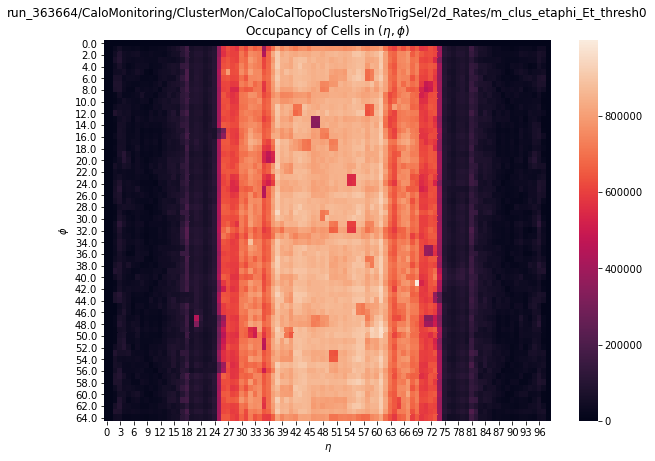

In [116]:
# import seaborn as sns
# import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
sns.heatmap(tmp.pivot(index='y',columns='x',values='occ'))
plt.title(r'run_363664/CaloMonitoring/ClusterMon/CaloCalTopoClustersNoTrigSel/2d_Rates/m_clus_etaphi_Et_thresh0' "\n" r'Occupancy of Cells in $(\eta,\phi)$')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$\phi$')

In [93]:
# Scale the values - see the thing on my phone
display(tmp[['occ']].max()[0])
display(tmp[['occ']].min()[0])

# Then you need to rerun the pivot table with the newly scaled values (needs between 0-255 to be like an image file...but the CNN might take it as is)

997649.0

0.0

<hr>

##### NEXT ACTIONS(update as you complete things and have new tasks to complete):
- figure out what specific or general histograms I will use for training the CNN
- see if the CNN can handle unscaled ... on the other hand if we can scale it like ATLAS scales the histograms themselves (see sawyers algorithm), then we could get better results?
- still need to figure out ground truth of what is a good vs a bad value...the express streams should include bad value but we dont have labels for if it is in fact bad or good
- process the csv files in the unprocessed express and unprocessed pMain folders together as a single database_dataframe (might need to optimize individual dfs for memory then concat them together into the database for best results
- consider if I will be using primarily TH1,TH2, or combinations of them to train CNN
- gather more datasets
- rework the CNN, because this formulation only is supposed to figure out what color is needed using the greyscale to train on and the color sets as the target values
 - we want to train on the 'greyscale' but use ? as the target values ; the target values should be a separate dataframe that looks like this pivoted frame and contain index=x,columns=y,values=TRUE_FALSE_VALUES_as_0_or_1

<br><br>

- work on more of the Thesis writing
- edit presentation for sawyer
- evaluate the CNN model, look to the linear regression resources I have for ideas on how to evaluate, look at the deep learning book and approaching ML book as well, use ttests/chi2 tests to also evaluate the model, consider confidence interval stuff too...look into all of that

##### Figure out what specific or general histograms I will use for training the CNN:
- (COMPLETED - for now) Initially, ReplicasPRocessingScript.py has used histogram 20(2d rates m_clus_Et_thresh1) as the histogram of choice

##### Process the csv files in the unprocessed express and unprocessed pMain folders together as a single database_dataframe (might need to optimize individual dfs for memory then concat them together into the database for best results
- (COMPLETED)

##### Still need to figure out ground truth of what is a good vs a bad value...the express streams should include bad value but we dont have labels for if it is in fact bad or good
- (COMPLETED - for now) Ground truth initially, based on first histogram will assume all express values are 0 for bad, and all pMain values are 1 for good

##### Consider if I will be using primarily TH1,TH2, or combinations of them to train CNN
- (Completed - for now) For now we are just using a single TH2, more on this later

##### Gather more datasets
(Waiting on initial results) - Not certain if we will actually need to do this yet. Technically we already ahve 56million datapoints which is over a 6GB csv

##### We want to train on the 'greyscale' but use ? as the target values ; the target values should be a separate dataframe that looks like this pivoted frame and contain index=x,columns=y,values=TRUE_FALSE_VALUES_as_0_or_1
- This issue has been partially resolved in process of preparing the initial histogram dataset
- (Again this issue has abeen partially resolved) So if we go back to our original dataframe we have above, if we add another feature called 'quality' encoded as 0/1/2 for good/okay/bad quality then this CNN should be able to train this 

In [ ]:
# Open the file that train_set is stored in as f
with open('train_set.npy', 'rb') as f:

    # Load and get a handle for train_set
    train_set = np.load(f)

# Open the file that train_set is stored in as f
with open('test_set.npy', 'rb') as f:
    
    # Load and get a handle for test_set
    test_set = np.load(f)

##### Next Actions (Update 7-16-21):
- edit presentation for sawyer by Monday(7-19-21)
- evaluate the CNN model, look to the linear regression resources I have for ideas on how to evaluate, look at the deep learning book and approaching ML book as well, use ttests/chi2 tests to also evaluate the model, consider confidence interval stuff too...look into all of that
- take extensive notes on and work on more of the Thesis writing
